In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from scipy import ndimage
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint
# from lipnet.lipreading.generators import BasicGenerator
# from lipnet.lipreading.callbacks import Statistics, Visualize
# from lipnet.lipreading.curriculums import Curriculum

from keras import backend as K
import numpy as np
from lipnet.utils.spell import Spell
from lipnet.core.decoders import Decoder
from lipnet.lipreading.helpers import labels_to_text
from lipnet.model2 import LipNet
import numpy as np
import datetime
import cv2
import skvideo.io
import dlib
from scipy.misc import imresize
# from lipnet.lipreading.aligns import Align
import imageio
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import random
import tensorflow as tf
import keras.backend as K
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)



FACE_PREDICTOR_PATH  = os.path.join('common','predictors','shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(FACE_PREDICTOR_PATH)

frames_count = 30
words_folder = 'training/unseen_speakers/TARGET/datasets/lipread_mp4'
words = ['EVERYONE', 'EVENTS', 'EVERYBODY', 'CLOUD', \
         'RIGHTS', 'AUTHORITIES', 'WITHIN', 'SEVERAL', \
         'ABSOLUTELY', 'WINDS', 'AFTERNOON', 'BETWEEN', \
         'TALKING', 'AGREEMENT', 'PRICES', 'MEETING', \
         'AFFAIRS', 'SERIOUS', 'SUNSHINE', 'OPPOSITION'] #words[:2]
print(words)
max_len = 12 #np.max([len(word) for word in words])
used_words = {''}
def datagen(data_partition = 'train', batch_size = 16):
    while True:
        counter = 0
        
        X_data = []#np.zeros((batch_size,))
        Y_data = []
        input_length = []
        label_length = []
        source_str = []
        while counter<batch_size:
#             print(counter)
            word_idx = np.random.randint(len(words))
            used_words.add(words[word_idx])
            train_folder = 'training/unseen_speakers/TARGET/datasets/lipread_mp4/{0}/{1}/'.format(words[word_idx],data_partition)
    #         print(train_folder)
            files = os.listdir(train_folder)
    #         print(files)
            paths = list(set([x.split('.')[0] for x in files]))
        
            idx = np.random.randint(len(paths))
            path = os.path.join(train_folder,paths[idx])
            frames = []
            for img_name in sorted(os.listdir(path)):
                img = cv2.imread(os.path.join(path,img_name))
                frames.append(img)
            frames = np.array(frames)
            if len(frames.shape)==4:
                frames = np.rollaxis(frames,2, start=1)
    #             print(path)
    #             print(frames.shape)
    #             print('---------')
                if 'numpy.ndarray' in str(type(frames)) \
                        and len(np.shape(frames))==4 \
                        and np.shape(frames)[1] == 100 \
                        and np.shape(frames)[2] == 50:

                    X_data.append(frames)


                    ####
                    Y_data.append([ord(c) - 65 for c in words[word_idx]]+[-1]*(max_len-len(words[word_idx])))
                    input_length.append(frames_count)
                    label_length.append(len(words[word_idx]))
                    source_str.append(words[word_idx])
                    counter+=1
                else:
                    continue
            else:
                print('error:', frames.shape, path)
                continue

        X_data = np.array(X_data).astype(np.float32) / 255 
        Y_data = np.array(Y_data)
        input_length = np.array(input_length)
        label_length = np.array(label_length)
        source_str = np.array(source_str)
        
        inputs = {'the_input': X_data,
                  'the_labels': Y_data,
                  'input_length': input_length,
                  'label_length': label_length,
                  'source_str': source_str  # used for visualization only
                  }
        outputs = {'ctc': np.zeros([batch_size])}
        
#         print('the_input:', inputs['the_input'].shape)
#         print('the_labels:', inputs['the_labels'].shape)
#         print('input_length:', inputs['input_length'].shape)
#         print('label_length:', inputs['label_length'].shape)
#         print('source_str:', inputs['source_str'].shape)
#         print('batch_frames_shape',X_data.shape, data_partition)
        yield (inputs, outputs)

['EVERYONE', 'EVENTS', 'EVERYBODY', 'CLOUD', 'RIGHTS', 'AUTHORITIES', 'WITHIN', 'SEVERAL', 'ABSOLUTELY', 'WINDS', 'AFTERNOON', 'BETWEEN', 'TALKING', 'AGREEMENT', 'PRICES', 'MEETING', 'AFFAIRS', 'SERIOUS', 'SUNSHINE', 'OPPOSITION']


In [3]:

def get_frames_mouth(detector, predictor, frames):
    MOUTH_WIDTH = 100
    MOUTH_HEIGHT = 50
    HORIZONTAL_PAD = 0.19
    normalize_ratio = None
    mouth_frames = []
    for frame in frames:
        dets = detector(frame, 1)
        shape = None
        for k, d in enumerate(dets):
            shape = predictor(frame, d)
            i = -1
        if shape is None: # Detector doesn't detect face, just return as is
            return frames
        mouth_points = []
        for part in shape.parts():
            i += 1
            if i < 48: # Only take mouth region
                continue
            mouth_points.append((part.x,part.y))
        np_mouth_points = np.array(mouth_points)

        mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

        if normalize_ratio is None:
            mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
            mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

            normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

        new_img_shape = (int(frame.shape[0] * normalize_ratio), int(frame.shape[1] * normalize_ratio))
        resized_img = imresize(frame, new_img_shape)

        mouth_centroid_norm = mouth_centroid * normalize_ratio

        mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
        mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
        mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
        mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

        mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

        mouth_frames.append(ndimage.rotate(mouth_crop_image, 90))
    print('shape mouth frames:',np.shape(mouth_frames))
    return np.array(mouth_frames)

In [4]:
# global lip_gen

run_name = datetime.datetime.now().strftime('%Y:%m:%d_%H:%M:%S')
run_name, start_epoch, stop_epoch, img_c, img_w, img_h, frames_n, absolute_max_string_len, minibatch_size = \
    run_name, 0, 1000, 3, 100, 50, 30, 12, 2



CURRENT_PATH = os.getcwd()+'/training/unseen_speakers'
DATASET_DIR  = os.path.join(CURRENT_PATH, 'datasets')
OUTPUT_DIR   = os.path.join(CURRENT_PATH, 'results')
LOG_DIR      = os.path.join(CURRENT_PATH, 'logs')
# if not os.path.exists('training/unseen_speakers/results/'+run_name):
#     os.makedirs('training/unseen_speakers/results/'+run_name)
if not os.path.exists('training/unseen_speakers/logs/'+run_name):
    os.makedirs('training/unseen_speakers/logs/'+run_name)

PREDICT_GREEDY      = False
PREDICT_BEAM_WIDTH  = 200
PREDICT_DICTIONARY  = os.path.join(CURRENT_PATH,'..','..','common','dictionaries','lfw.txt')
FACE_PREDICTOR_PATH  = os.path.join(CURRENT_PATH,'..','..','common','predictors','shape_predictor_68_face_landmarks.dat')

# def curriculum_rules(epoch):
#     return { 'sentence_length': -1, 'flip_probability': 0.5, 'jitter_probability': 0.05 }


# # def train(run_name, start_epoch, stop_epoch, img_c, img_w, img_h, frames_n, absolute_max_string_len, minibatch_size):
# curriculum = Curriculum(curriculum_rules)
# lip_gen = BasicGenerator(dataset_path=DATASET_DIR, #vtype = "face", face_predictor_path = FACE_PREDICTOR_PATH,
#                             minibatch_size=minibatch_size,
#                             img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n,
#                             absolute_max_string_len=absolute_max_string_len,
#                             curriculum=curriculum, start_epoch=start_epoch).build()
# lip_gen_train = datagen(data_partition='train', batch_size=5)
# lip_gen_val = datagen(data_partition='val', batch_size=5)

lipnet = LipNet(img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n,
                        absolute_max_string_len=absolute_max_string_len, output_size=27)
# lipnet.summary()

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
lipnet.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam, metrics=['accuracy'])


# spell = Spell(path=PREDICT_DICTIONARY)
# decoder = Decoder(greedy=PREDICT_GREEDY, beam_width=PREDICT_BEAM_WIDTH,
#                   postprocessors=[labels_to_text, spell.sentence])

# define callbacks
# statistics  = Statistics(lipnet, lip_gen.next_val(), decoder, 256, output_dir=os.path.join(OUTPUT_DIR, run_name))
# visualize   = Visualize(os.path.join(OUTPUT_DIR, run_name), lipnet, lip_gen.next_val(), decoder, num_display_sentences=minibatch_size)
# tensorboard = TensorBoard(log_dir=os.path.join(LOG_DIR, run_name))
# # csv_logger  = CSVLogger(os.path.join(LOG_DIR, "{}-{}.csv".format('training',run_name)), separator=',', append=True)
# checkpoint  = ModelCheckpoint(os.path.join(OUTPUT_DIR, "weights_lfw.hdf5")
#                               , monitor='val_loss'
#                               , verbose=1
#                               , save_best_only=True
#                               , mode='auto'
#                               , period=1)
    
    # x = next(lip_gen.next_val())
    # for i in x:
    #     print('$$$$$----------', type(i))

# weight_file = os.path.join(OUTPUT_DIR, 'weights_lfw.hdf5')
weight_file = os.path.join(OUTPUT_DIR, 'weights_lfw-crop-v2.hdf5')
lipnet.model.load_weights(weight_file)

# from keras.utils import plot_model
# from IPython.display import HTML, display, clear_output, SVG
# from keras.utils.vis_utils import model_to_dot
# plot_model(lipnet.model, show_layer_names=True, show_shapes=True, to_file='model.png')
# SVG(model_to_dot(lipnet.model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

y_pred (?, 30, 27)


In [5]:
g=datagen(data_partition='test', batch_size=2)
x,y = next(g)
X = x['the_input'][1]

y_test = x['source_str']

In [6]:
X.shape

(30, 100, 50, 3)

EVERYONE


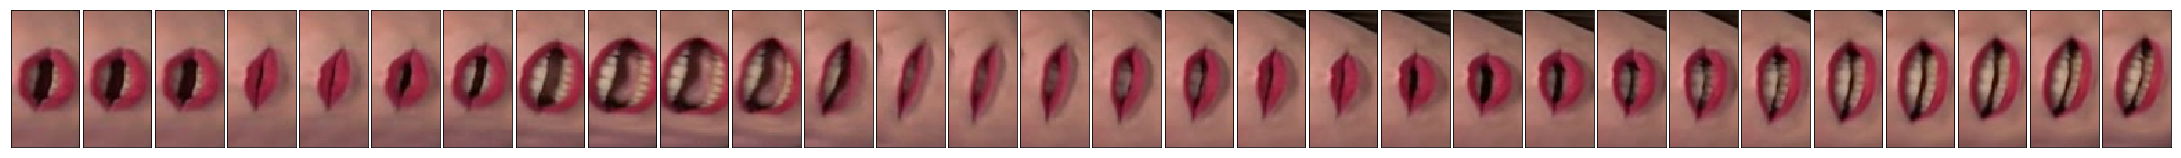

In [7]:
# im = batch_frames[1][25]
import matplotlib.pyplot as plt
%matplotlib inline
# generator = datagen(min_row_number=0,max_row_number=200000, batch_size= 6)
# X,Y = next(generator)
print(y_test[1])
# print(X.shape, Y.shape)
def plot_data(x,ax):
#     x = x.reshape((size,size))
    ax.imshow(x)
#     if y is not None:
#         ax.scatter(y[0::2] , y[1::2] , marker='x', s=10)
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    plot_data(X[i], ax)


In [8]:
# from keras.layers import Input
# from keras.models import Model
# layer_name = 'softmax'
# input_shape =(frames_n, img_w, img_h, img_c)
# input_data = Input(name='the_input', shape=input_shape, dtype='float32')
# intermediate_layer_model = Model(inputs=input_data,
#                                  outputs=lipnet.model.get_layer(layer_name).output)

# intermediate_layer_model.summary()
from tqdm import tqdm
input_length = 30
y_test = []
y_pred = []
g=datagen(data_partition='test', batch_size=1)
for i in tqdm(range(1024)):
    x,y = next(g)
    X = x['the_input']
    y_test.append(x['source_str'])
    sm_out = lipnet.predict(X)
    decoded = K.ctc_decode(y_pred=sm_out, input_length=(30,) ,greedy=True, beam_width=100, top_paths=10)
    paths = [path.eval(session=K.get_session()) for path in decoded[0]]
    logprobs  = decoded[1].eval(session=K.get_session())
    preds = []
    for path in paths:
        preds.append(''.join([chr(65+v) for v in path[0] ]))
    preds = np.array(preds)
    y_pred.append(preds)

100%|██████████| 1024/1024 [12:46<00:00,  1.34it/s]


In [9]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)
y_test.shape, y_pred.shape

((1024, 1), (1024, 1))

In [10]:
# y_pred, y_test

In [11]:
# # print(paths)
# # print(logprobs)
# preds = []
# for path in paths:
#     preds.append(''.join([chr(65+v) for v in path[0] ]))
# preds

In [12]:
# import os
# words_folder = 'training/unseen_speakers/datasets/lipread_mp4'
# words = os.listdir(words_folder)
# print('\n'.join(words))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

(1024, 1) (1024, 1)


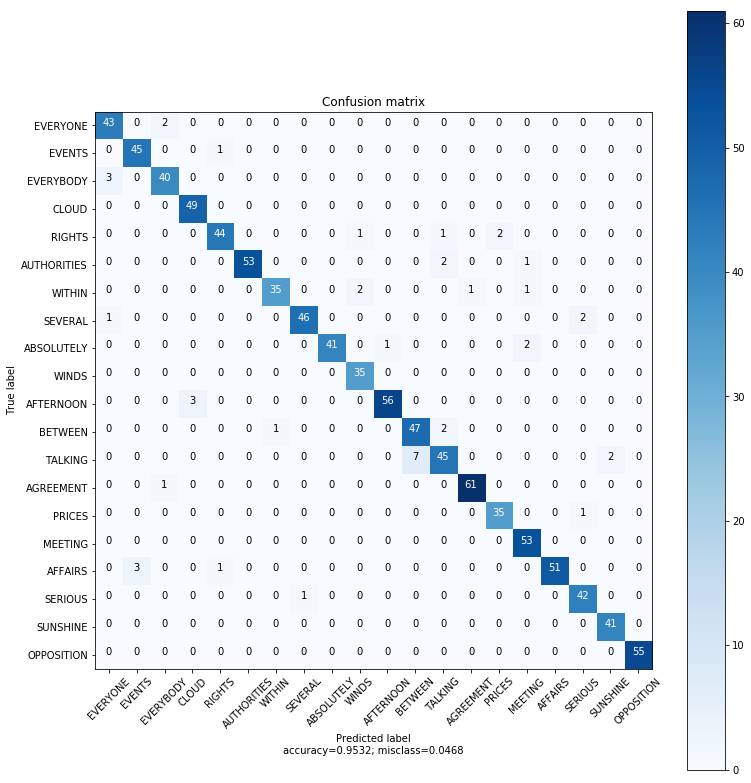

In [14]:
from sklearn.metrics import confusion_matrix
import pylab as pl

labels = words
print(y_test.shape,y_pred.shape)
cm = confusion_matrix(y_test, y_pred, labels)
plot_confusion_matrix(cm,words)

In [15]:
', '.join(words)

'EVERYONE, EVENTS, EVERYBODY, CLOUD, RIGHTS, AUTHORITIES, WITHIN, SEVERAL, ABSOLUTELY, WINDS, AFTERNOON, BETWEEN, TALKING, AGREEMENT, PRICES, MEETING, AFFAIRS, SERIOUS, SUNSHINE, OPPOSITION'